# 您是否有 Gurobi WLS？
使用下面的单元格添加您的许可证信息并继续。

如果没有,也不用担心。您可以使用[免费有限许可证](https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/price_optimization/price_optimization_gurobiML.ipynb)来完成此笔记本的精简版本。

In [ ]:
params = {
"WLSACCESSID": ---- ,
"WLSSECRET":  ---- ,
"LICENSEID": ---- ,
}

# 第二部分：使用数学优化进行鳄梨定价和供应

这是一个价格优化示例的第二部分：[多少钱合适？使用数学优化进行鳄梨定价和供应](https://github.com/Gurobi/modeling-examples/tree/master/price_optimization)

在第一部分中,使用普通线性回归模型(OLS)基于[Hass鳄梨委员会](https://hassavocadoboard.com/)(HAB)的数据建立了价格和需求之间的关系。

第二部分用训练好的`Scikit-learn`模型替换OLS模型,并使用[Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/#)包将其嵌入Gurobi优化模型中。

在本例中,我们还将使用`gurobipy-pandas`,这是另一个Gurobi开源包,作为连接pandas与gurobipy的便捷(可选)包装器。

如果您已经熟悉另一个笔记本中的示例,可以直接跳转到[构建回归模型](#Part-2:-Predict-the-Sales)
然后转到[构建优化问题](#Part-3:-Optimize-for-Price-and-Supply-of-Avocados)。

**目标**：开发一个数据科学和决策管道,用于鳄梨的定价和分销以最大化收入。

为实现这一目标,笔记本将分三个阶段进行:

1. 快速回顾HAB数据
2. 建立一个预测模型,将鳄梨需求作为价格、地区、年份和季节性的函数。
3. 设计一个优化模型,在考虑运输和成本的同时设置最佳价格和供应量以最大化净收入。

## 加载包和准备数据集

就像第一个示例一样,我们使用真实的HAB销售数据。


In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

来自HAB的数据集包含2019-2022年的销售数据。这些数据通过[Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020)上之前从HAB下载的2015-2018年销售数据进行了补充。

本笔记本将跳过第一个版本示例中的大部分预处理。

In [2]:
data_url = "https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/"
avocado = pd.read_csv(data_url+"HAB_data_2015to2022.csv")
avocado["date"] = pd.to_datetime(avocado["date"])
avocado = avocado.sort_values(by="date")
avocado

,date,units_sold,price,region,year,month,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0
...,...,...,...,...,...,...,...
3396,2022-05-15,0.445830,1.513707,Northern_New_England,2022,5,1
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,1


上述数据框中的一个地区是`Total_US`,因此我们可以创建一个不包括总计的地区列表,现在可以用它来子集化数据。它稍后也会在示例中使用。

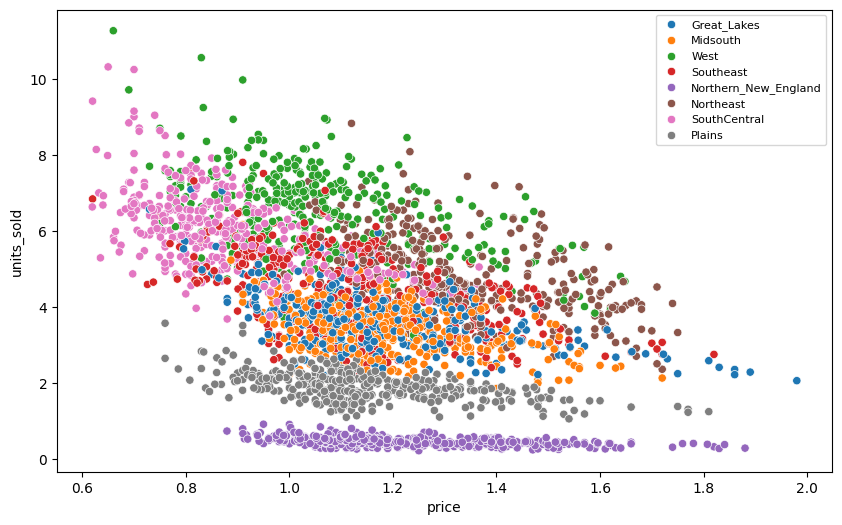

In [3]:
regions = [
    "Great_Lakes",
    "Midsouth",
    "Northeast",
    "Northern_New_England",
    "SouthCentral",
    "Southeast",
    "West",
    "Plains"
]
df = avocado[(avocado.region.isin(regions))] # & (avocado.peak==0)
df.drop(columns=['date']) #,'peak'

plt.figure(figsize=(10, 6))
r_plt = sns.scatterplot(data=df, x='price', y='units_sold', hue='region')
r_plt.legend(fontsize=8)
plt.show()

## 预测销售量

在这个示例的第一个版本中,对输入数据进行了更多分析并进行了一些可视化。在这里,我们将直接进行预测模型训练,首先将数据集随机分成70%的训练数据和30%的测试数据。

In [4]:
from sklearn.model_selection import train_test_split

X = df[["region", "price", "year", "peak"]]
y = df["units_sold"]
# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

需要注意的是,region(地区)是一个分类变量,我们将使用Scikit Learn的`OneHotEncoder`来转换该变量。我们还使用标准化器来处理价格和年份索引,并通过`make_column_transformer`将所有这些组合在`Column Transformer`中。

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

feat_transform = make_column_transformer(
    (OneHotEncoder(drop="first"), ["region"]),
    (StandardScaler(), ["price", "year"]),
    ("passthrough", ["peak"]),
    verbose_feature_names_out=False,
    remainder='drop'
)

回归模型是一个由`Column Transformer`和我们想要用于回归的模型类型组成的管道。为了进行比较,我们将继续使用线性回归。

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [7]:
reg = make_pipeline(feat_transform, LinearRegression())
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("%0.4f R^2 with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9022 R^2 with a standard deviation of 0.0101


In [8]:
# 在测试集上计算模型得分
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"测试集中的R^2值为 {np.round(r2_score(y_test, y_pred),5)}")

测试集中的R^2值为 0.91365


我们可以观察到测试集中有一个不错的$R^2$值。现在我们将对整个数据集进行训练拟合。

In [9]:
reg.fit(X, y)
y_pred_full = reg.predict(X)
print(f"The R^2 value in the full dataset is {np.round(r2_score(y, y_pred_full),5)}")

The R^2 value in the full dataset is 0.90667


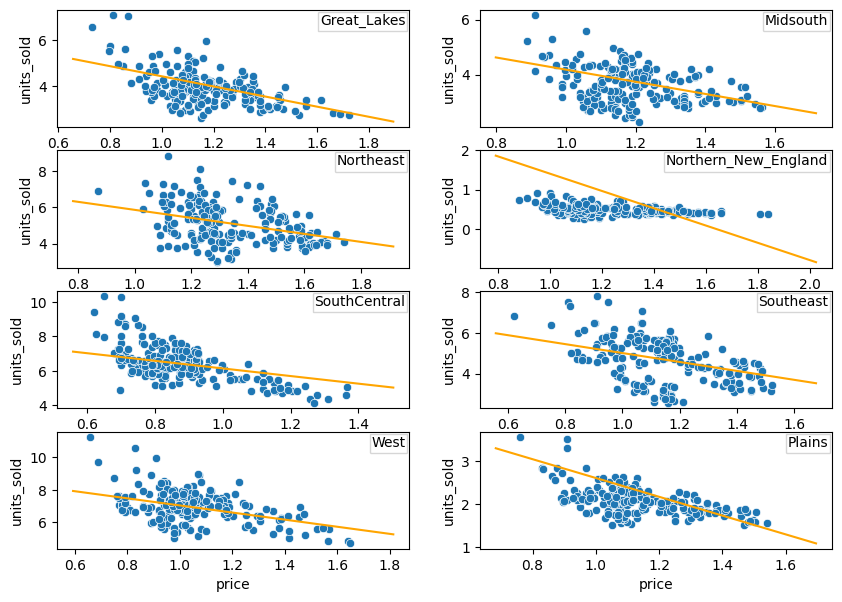

In [10]:
year = 2019
peak_or_not = 1
fig, axs = plt.subplots(4, 2, figsize=(10, 7))

for k in range(8):
  r = regions[k]
  i = k//2
  j = k%2
  X_r = df.loc[(df.region==r) & (df.peak==peak_or_not),["price", "year","units_sold"]]
  x_plt = X_r.price
  p_new = np.linspace(.9*min(x_plt),1.1*max(x_plt),50)
  x_new = pd.DataFrame(
      data={
          "year": year,
          "peak": peak_or_not,
          "region": r,
          "price": p_new
      },
      index=range(50)
  )
  x_new['units_sold'] = reg.predict(x_new)
  sns.lineplot(data=x_new, x='price', y='units_sold', c='orange', ax=axs[i,j])
  sns.scatterplot(data=X_r, x='price', y='units_sold', legend=0, ax=axs[i,j])
  axs[i, j].legend(title=r, loc='upper right', prop={'size': 3}, handles = []);

## 优化鳄梨的价格和供应

这里快速回顾一下数学优化模型公式的符号表示。下标$r$将用于表示每个地区。
### 输入参数
- $d(p,r)$: 当鳄梨价格为$p$时地区$r$的预测需求量
- $B$: 可在各地区分配的鳄梨总数
- $c_{waste}$: 每个浪费的鳄梨的成本($\$$)
- $c^r_{transport}$: 将一个鳄梨运输到地区$r$的成本($\$$)
- $a_{min},a_{max}$: 每个鳄梨的最低和最高价格($\$$)
- $b^r_{min},b^r_{max}$: 分配给地区$r$的鳄梨数量的最小值和最大值

以下代码为这些参数设置值。你可以随意调整这些参数,看看优化模型的解决方案会如何变化。


In [11]:
# 设置和参数
year = 2022
B = 30  # 鳄梨供应总量
peak_or_not = 0  # 1表示旺季; 0表示不是
c_waste = 0.1  # 每个浪费的鳄梨的成本($)
# 运输一个鳄梨的成本
c_transport = pd.Series(
    {
        "Great_Lakes": 0.3,
        "Midsouth": 0.1,
        "Northeast": 0.4,
        "Northern_New_England": 0.5,
        "SouthCentral": 0.3,
        "Southeast": 0.2,
        "West": 0.2,
        "Plains": 0.2,
    }, name='transport_cost'
)
c_transport = c_transport.loc[regions]

a_min = 0  # 鳄梨最低价格
a_max = 2  # 鳄梨最高价格

# 从数据集获取价格和库存数量的上下界
data = pd.concat([c_transport,
                  df.groupby("region")["units_sold"].min().rename('min_delivery'),
                  df.groupby("region")["units_sold"].max().rename('max_delivery'),
                  df.groupby("region")["price"].max().rename('max_price'),], axis=1)

data

,transport_cost,min_delivery,max_delivery,max_price
Great_Lakes,0.3,2.063574,7.094765,1.980000
Midsouth,0.1,1.845443,6.168572,1.720000
Northeast,0.4,2.364424,8.836406,1.750000
Northern_New_England,0.5,0.219690,0.917984,1.880000
SouthCentral,0.3,3.687130,10.323175,1.366446
Southeast,0.2,2.197764,7.810475,1.820000
West,0.2,3.260102,11.274749,1.648013
Plains,0.2,1.058938,3.575499,1.810000


#### 安装和导入Gurobi包

In [12]:
# %%capture
# %pip install gurobipy_pandas #这也会安装gurobipy
# %pip install gurobi-machinelearning
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr

### 为回归创建固定特征的数据框

我们现在开始在优化模型中创建回归输入,使用固定特征,并使用`gurobipy-pandas`来更容易地使用pandas数据创建gurobipy模型。

首先,创建一个包含我们优化问题中固定特征的数据框。
它使用地区作为索引(我们想要使用一个回归来预测所有地区的需求),并具有三个
对应于固定特征的列:

* `year`
* `peak`的值为`peak_or_not`
* `region`重复地区名称。

让我们显示数据框以确保它是正确的。

In [13]:
feats = pd.DataFrame(
    data={
        "year": year,
        "peak": peak_or_not,
        "region": regions,
    },
    index=regions
)
feats

,year,peak,region
Great_Lakes,2022,0,Great_Lakes
Midsouth,2022,0,Midsouth
Northeast,2022,0,Northeast
Northern_New_England,2022,0,Northern_New_England
SouthCentral,2022,0,SouthCentral
Southeast,2022,0,Southeast
West,2022,0,West
Plains,2022,0,Plains


### 决策变量

让我们现在定义决策变量。在我们的模型中,我们想要存储每个地区的价格和分配的鳄梨数量。我们还需要变量来跟踪预计将销售多少鳄梨以及预计会浪费多少。使用以下符号来模拟这些决策变量。

- $p$ 每个地区鳄梨的价格($\$$)
- $x$ 供应给每个地区的鳄梨数量
- $s$ 每个地区预计销售的鳄梨数量
- $u$ 每个地区预计未售出(浪费)的鳄梨数量
- $d$ 每个地区的预测需求量

所有这些变量都使用gurobipy-pandas创建,通过`gppd.add_vars`函数它们获得与`data`数据框相同的索引。

In [ ]:
# %%capture
import gurobipy as gp

env = gp.Env(params=params)

#在Gurobi环境中创建模型
m = gp.Model("Avocado_Price_Allocation", env=env)

p = gppd.add_vars(m, data, name="price", lb=a_min, ub=a_max) # 每个地区鳄梨的价格'max_price'
x = gppd.add_vars(m, data, name="x", lb='min_delivery', ub='max_delivery') # 供应给每个地区的鳄梨数量
s = gppd.add_vars(m, data, name="s") # 给定价格下每个地区的预测销售量
u = gppd.add_vars(m, data, name="w") # 未售出库存,每个地区的过度浪费
d = gppd.add_vars(m, data, lb=-gp.GRB.INFINITY, name="demand") # 添加回归的变量
m.update()

In [ ]:
# 显示其中一个变量
p

Great_Lakes                      <gurobi.Var price[Great_Lakes]>
Midsouth                            <gurobi.Var price[Midsouth]>
Northeast                          <gurobi.Var price[Northeast]>
Northern_New_England    <gurobi.Var price[Northern_New_England]>
SouthCentral                    <gurobi.Var price[SouthCentral]>
Southeast                          <gurobi.Var price[Southeast]>
West                                    <gurobi.Var price[West]>
Plains                                <gurobi.Var price[Plains]>
Name: price, dtype: object

### 添加供应约束

我们现在引入约束条件。第一个约束是确保
供应的鳄梨总数等于$B$,这可以用数学形式
表示如下。

\begin{align*} \sum_{r} x_r &= B \end{align*}


In [17]:
m.addConstr(x.sum() == B)
m.update()

### 添加定义销售量的约束

简单回顾一下,销售量是分配数量和预测需求量的最小值,即$s_r = \min \{x_r,d_r(p_r)\}$。这种关系可以通过以下两个约束来建模,对每个地区$r$:

\begin{align*} s_r &\leq x_r  \\
s_r &\leq d(p_r,r) \end{align*}

在这种情况下,我们使用gurobipy-pandas的`add_constrs`函数,考虑到上面的不等式,这个函数使用起来很直观。

In [18]:
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, x)
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, d)
m.update()

### 添加浪费约束

最后,我们应该定义每个地区预计未售出的鳄梨数量,这由供应数量减去预计销售数量得出。我们可以对每个地区$r$用数学形式表示为:

\begin{align*} u_r &= x_r - s_r \end{align*}

In [19]:
gppd.add_constrs(m, u, gp.GRB.EQUAL, x - s)
m.update()

### 添加预测需求的约束
首先,我们为预测器约束创建完整的输入。我们将`p`变量和固定特征连接起来。请记住,预测价格是地区、年份和旺季/淡季的函数。

In [20]:
m_feats = pd.concat([feats, p], axis=1)[["region", "price", "year","peak"]]
m_feats

,region,price,year,peak
Great_Lakes,Great_Lakes,<gurobi.Var price[Great_Lakes]>,2022,0
Midsouth,Midsouth,<gurobi.Var price[Midsouth]>,2022,0
Northeast,Northeast,<gurobi.Var price[Northeast]>,2022,0
Northern_New_England,Northern_New_England,<gurobi.Var price[Northern_New_England]>,2022,0
SouthCentral,SouthCentral,<gurobi.Var price[SouthCentral]>,2022,0
Southeast,Southeast,<gurobi.Var price[Southeast]>,2022,0
West,West,<gurobi.Var price[West]>,2022,0
Plains,Plains,<gurobi.Var price[Plains]>,2022,0


现在,我们只需调用
[add_predictor_constr](https://gurobi-machinelearning.readthedocs.io/en/stable/api/AbstractPredictorConstr.html#gurobi_ml.add_predictor_constr)
来将连接特征和需求的约束插入模型`m`中。

请务必保持上述列的顺序,否则您将看到错误。这些列必须与训练数据的顺序相同。

In [21]:
pred_constr = add_predictor_constr(m, reg, m_feats, d)
pred_constr.print_stats()
print(m)

Model for pipe:
88 variables
24 constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 10)           24           16            0            0

lin_reg               (8, 1)           64            8            0            0

--------------------------------------------------------------------------------
<gurobi.Model Continuous instance Avocado_Price_Allocation: 49 constrs, 128 vars, Parameter changes: LicenseID=874302>


### 设置目标函数

目标是最大化**净收入**,即价格和数量的乘积减去所有地区的成本。该模型假设采购成本是固定的(因为数量$B$是固定的),因此不包括在内。

使用定义的决策变量,目标函数可以写成如下形式。

\begin{align} \textrm{最大化} &  \sum_{r}  (p_r * s_r - c_{waste} * u_r -
c^r_{transport} * x_r)& \end{align}

In [22]:
m.setObjective((p * s).sum() - c_waste * u.sum() - (c_transport * x).sum(),
               gp.GRB.MAXIMIZE)

### 启动求解器

在我们的模型中,目标函数是**二次的**,因为我们取价格
和预测销售量的乘积,这两个都是变量。最大化二次
项被称为**非凸**,我们通过设置
[Gurobi NonConvex
参数](https://www.gurobi.com/documentation/10.0/refman/nonconvex.html)为
$2$来指定这一点。

In [23]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

WLS license - registered to yurchisin@gurobi.com
Optimize a model with 49 rows, 128 columns and 184 nonzeros
Model fingerprint: 0x23b32dad
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 2e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 24 rows and 96 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 32 rows and 104 columns
Presolve time: 0.00s
Presolved: 34 rows, 33 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 0 integer (0 binary)

Root relaxation: objective 5.247921e+01, 38 iterations, 0.00 seconds (0.00 work units

求解器在不到一秒的时间内解决了优化问题。现在让我们
通过将最优解存储在Pandas数据框中来分析它。

In [24]:
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Historical_Max"] = data.max_price
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = u.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(3)


 The optimal net revenue: $35.864740 million


,Price,Historical_Max,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,1.489,1.980,3.282,3.282,0.000,3.282
Midsouth,1.384,1.720,6.169,3.271,2.897,3.271
Northeast,1.865,1.750,3.889,3.889,0.000,3.889
Northern_New_England,1.192,1.880,0.918,0.918,0.000,0.918
SouthCentral,1.878,1.366,4.139,4.139,0.000,4.139
Southeast,1.572,1.820,3.921,3.685,0.236,3.685
West,2.000,1.648,5.000,4.759,0.241,4.759
Plains,1.028,1.810,2.682,2.485,0.197,2.485


我们还可以检查Gurobi解对回归模型的估计误差。

In [25]:
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)

Maximum error in approximating the regression 8.88178e-16


## 更改回归模型
我们的回归模型有一些缺陷,所以让我们尝试另一种模型类型,看看它产生的拟合效果如何,以及这将如何影响优化模型。

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
reg = make_pipeline(feat_transform, GradientBoostingRegressor(n_estimators=100, max_leaf_nodes = 20,
                                              loss = 'absolute_error', random_state = 123))
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("%0.4f R^2 with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# 对全部训练数据进行拟合
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"测试集中的R^2值为 {np.round(r2_score(y_test, y_pred),5)}")
reg.fit(X, y)
y_pred_full = reg.predict(X)
print(f"完整数据集中的R^2值为 {np.round(r2_score(y, y_pred_full),5)}")

0.9399 R^2 with a standard deviation of 0.0057
The R^2 value in the test set is 0.94608
The R^2 value in the full dataset is 0.94706


考虑到新的回归模型,优化模型的大部分内容保持不变。因此要更新优化,我们`移除`之前的预测,然后像之前一样添加新的预测。

In [28]:
pred_constr.remove()
pred_constr = add_predictor_constr(m, reg, m_feats, d)
pred_constr.print_stats()
m.update()

Model for pipe0:
6688 variables
824 constraints
6372 general constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 10)           24           16            0            0

gbtree_reg            (8, 1)         6664          808            0         6372

--------------------------------------------------------------------------------


创建新模型后,我们可以重新求解优化问题并提取新的解

In [29]:
m.optimize()

solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Max_Price"] = data.max_price
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = u.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(3)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

WLS license - registered to yurchisin@gurobi.com
Optimize a model with 849 rows, 6728 columns and 6704 nonzeros
Model fingerprint: 0xaa31d069
Model has 8 quadratic objective terms
Model has 6372 general constraints
Variable types: 928 continuous, 5800 integer (5800 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-02, 2e+03]
  RHS range        [1e+00, 2e+03]
  GenCon rhs range [2e-04, 3e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 395 rows and 0 columns
Presolve removed 0 rows and 5799 columns
Presolve time: 0.40s
Presolved: 1261 rows, 938 columns, 3889 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 905 integer (905 binary)

R

,Price,Max_Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,2.00,1.980,3.620,3.620,0.000,3.620
Midsouth,2.00,1.720,6.169,3.267,2.901,3.267
Northeast,2.00,1.750,4.449,4.449,0.000,4.449
Northern_New_England,1.85,1.880,0.522,0.522,0.000,0.522
SouthCentral,2.00,1.366,4.350,4.350,0.000,4.350
Southeast,2.00,1.820,4.115,4.115,0.000,4.115
West,2.00,1.648,5.292,4.909,0.383,4.909
Plains,2.00,1.810,1.485,1.485,0.000,1.485


In [30]:
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Max_Price"] = data.max_price
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = u.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(3)


 The optimal net revenue: $45.799412 million


,Price,Max_Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,2.00,1.980,3.620,3.620,0.000,3.620
Midsouth,2.00,1.720,6.169,3.267,2.901,3.267
Northeast,2.00,1.750,4.449,4.449,0.000,4.449
Northern_New_England,1.85,1.880,0.522,0.522,0.000,0.522
SouthCentral,2.00,1.366,4.350,4.350,0.000,4.350
Southeast,2.00,1.820,4.115,4.115,0.000,4.115
West,2.00,1.648,5.292,4.909,0.383,4.909
Plains,2.00,1.810,1.485,1.485,0.000,1.485


检查新模型如何拟合整体数据集


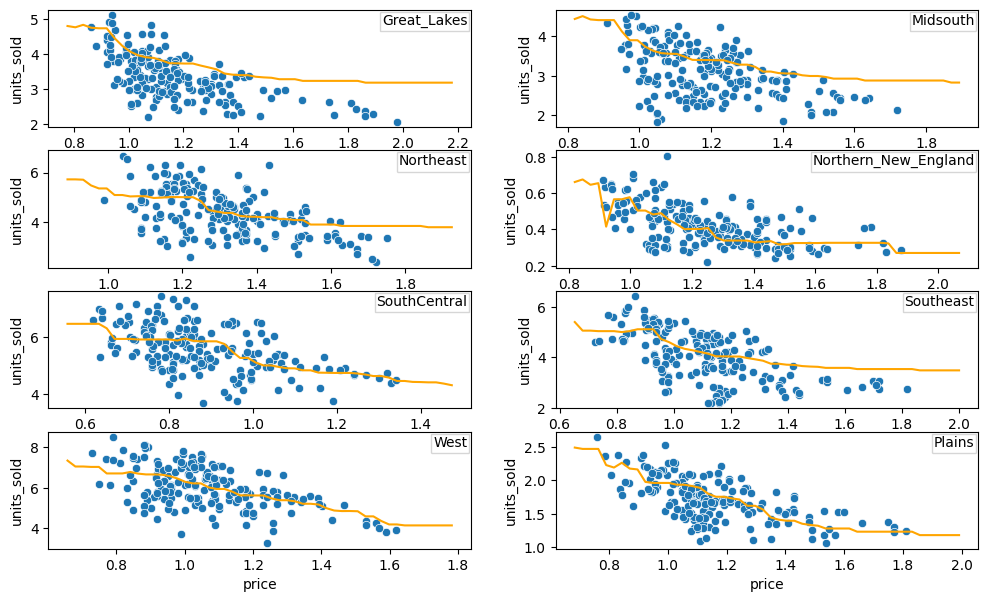

In [31]:
year = 2019
fig, axs = plt.subplots(4, 2, figsize=(12, 7))

for k in range(8):
  r = regions[k]
  i = k//2
  j = k%2
  X_r = df.loc[(df.region==r) & (df.peak==peak_or_not),["price", "year","units_sold"]]
  x_plt = X_r.price
  p_new = np.linspace(.9*min(x_plt),1.1*max(x_plt),50)
  x_new = pd.DataFrame(
      data={
          "year": year,
          "peak": peak_or_not,
          "region": r,
          "price": p_new
      },
      index=range(50)
  )
  x_new['units_sold'] = reg.predict(x_new)
  sns.lineplot(data=x_new, x='price', y='units_sold', c='orange', ax=axs[i,j])
  sns.scatterplot(data=X_r, x='price', y='units_sold',legend=0, ax=axs[i,j])
  axs[i, j].legend(title=r, loc='upper right', prop={'size': 3}, handles = []);

这是对使用Gurobi机器学习包的入门介绍。要了解更多关于此示例的信息,请参见[Github上的价格优化示例](https://github.com/Gurobi/modeling-examples/tree/master/price_optimization)
以及如何交互式地使用该模型。

版权所有 © 2023 Gurobi Optimization, LLC